In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib

import sklearn

#normalization
from sklearn import preprocessing

#oe hot encoder
from sklearn.preprocessing import OneHotEncoder

#train/test split
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

#metrics
from sklearn.metrics import accuracy_score

#baseline linear regression
from sklearn import linear_model
#baseline RF
from sklearn.ensemble import RandomForestClassifier

#dnn
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import DNN

#keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


In [3]:
df_train = pd.read_csv('train.csv')
print(df_train.shape)
df_train

y = df_train.label.values
print(y.shape)

df_train = df_train.drop(['label'], axis=1)
df_train /= 255
print(df_train.shape)

X = df_train.values

(42000, 785)
(42000,)
(42000, 784)


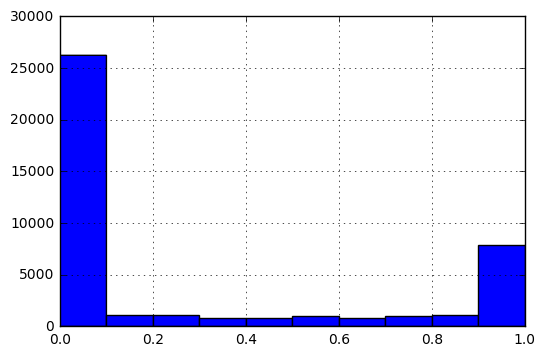

In [14]:
df_train.pixel300.hist()

In [15]:
df_train.pixel300.describe()

count    42000.000000
mean         0.279962
std          0.401214
min          0.000000
25%          0.000000
50%          0.000000
75%          0.647059
max          1.000000
Name: pixel300, dtype: float64

In [4]:
test_size = 0.05

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=test_size, random_state=0)

X_train_k = X_train
X_dev_k = X_dev

enc = OneHotEncoder()
Y_train_k = enc.fit_transform(y_train.reshape(-1, 1)).todense().A
Y_dev_k = enc.transform(y_dev.reshape(-1, 1)).todense().A

X_train_my = X_train_k.T
X_dev_my = X_dev_k.T
Y_train_my = Y_train_k.T
Y_dev_my = Y_dev_k.T

print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)

(39900, 784)
(39900,)
(2100, 784)
(2100,)


In [45]:
np.random.seed(0) # set a seed so that the results are consistent

clfs = []
clfs.append(sklearn.linear_model.LogisticRegression())
clfs.append(RandomForestClassifier(n_estimators=100, n_jobs=-1))

for clf in clfs:
    clf.fit(X_train, y_train);
    predictions = clf.predict(X_train)
    accuracy = accuracy_score(predictions, y_train)
    predictions = clf.predict(X_dev)
    accuracy2 = accuracy_score(predictions, y_dev)
    print(type(clf), accuracy, accuracy2)

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 1.0 0.963333333333


In [ ]:
<class 'sklearn.linear_model.logistic.LogisticRegression'> 0.930927318296 0.919523809524
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 1.0 0.963333333333

In [4]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, verbose):
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose != None and epoch % self.verbose == 0:
            print(epoch, logs['loss'], logs['acc'], logs['val_acc'])        

In [53]:
np.random.seed(0) # set a seed so that the results are consistent
#initializer = keras.initializers.RandomNormal(stddev=0.01)
initializer = keras.initializers.lecun_normal()
regularizer = None
#regularizer = regularizers.l2(0.01)
model = Sequential()
model.add(Dense(200, input_dim=X_train_k.shape[1], kernel_initializer=initializer, activation='tanh', kernel_regularizer=regularizer))
model.add(Dense(50, kernel_initializer=initializer, activation='tanh', kernel_regularizer=regularizer))
model.add(Dense(10, kernel_initializer=initializer, activation='softmax', kernel_regularizer=regularizer))
optimizer = optimizers.SGD(lr=0.1, momentum=0.9)
#optimizer = optimizers.Adam(lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [54]:
np.random.seed(0) # set a seed so that the results are consistent
initial_epoch = 0
epochs = 100
#batch_size = int(X_train_k.shape[0])
batch_size = 256
verbose = 0
verbose2 = 10
results_k = model.fit(X_train_k, Y_train_k, batch_size=batch_size, epochs=epochs, callbacks=[MyCallback(verbose2)], validation_data = (X_dev_k, Y_dev_k), verbose=verbose, initial_epoch=initial_epoch)
Y_predict_k = model.predict(X_train_k)
print('Accuracy train', accuracy_score(Y_train_k.argmax(axis=1), Y_predict_k.argmax(axis=1)))
Y_predict_k = model.predict(X_dev_k)
print('Accuracy dev', accuracy_score(Y_dev_k.argmax(axis=1), Y_predict_k.argmax(axis=1)))

0 0.746379182333 0.763208020182 0.79619047619
10 0.779616208495 0.767794486293 0.699999999886
20 0.799104182864 0.768972430916 0.751428571542
30 0.8281849742 0.75383458658 0.763809523469
40 0.771894529607 0.771904762042 0.789047619161
50 0.762332609662 0.769523809458 0.771904761791
60 0.713015390399 0.799423559011 0.78619047585
70 0.720382317499 0.783884711911 0.824761905103
80 0.742167330789 0.77774436101 0.783809523923
90 0.616780752329 0.827694235703 0.848095238776
Accuracy train 0.834711779449
Accuracy dev 0.825238095238


In [ ]:
200/50/10 lr=0.1/epochs=100/batch_size=256
Accuracy train 0.999674185464
Accuracy dev 0.972857142857

200/50/10 lr=0.1/epochs=100/batch_size=256/beta=0.9
Accuracy train 1.0
Accuracy dev 0.979047619048

200/50/10 lr=0.1/epochs=100/batch_size=256/beta=0.9/adam **bad
Accuracy train 0.834711779449
Accuracy dev 0.825238095238

200/50/10 lr=0.01/epochs=100/batch_size=256/beta=0.9/adam
Accuracy train 0.985463659148
Accuracy dev 0.96619047619

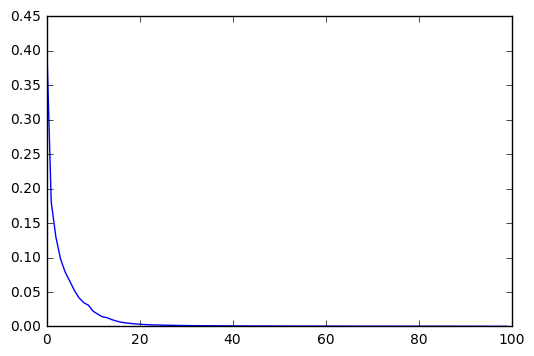

In [34]:
plt.plot(results_k.history['loss'])
plt.show()

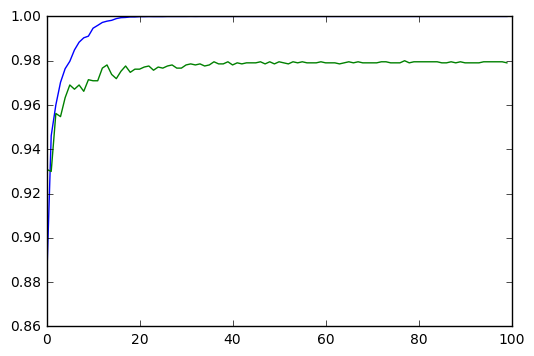

In [35]:
plt.plot(results_k.history['acc'])
plt.plot(results_k.history['val_acc'])
plt.show()

In [6]:
print(X_train_my.shape)
print(Y_train_my.shape)
print(X_dev_my.shape)
print(Y_dev_my.shape)

(784, 39900)
(10, 39900)
(784, 2100)
(10, 2100)


In [5]:
importlib.reload(DNN)

<module 'DNN' from 'C:\\Users\\mircean\\git\\ML\\DeepLearning\\DNN.py'>

In [10]:
#random seed for parameters init
np.random.seed(0) 
dnn = DNN.DNN()
dnn.add_input_layer(X_train_my.shape[0])
dnn.add_layer(200, np.tanh)
dnn.add_layer(50, np.tanh)
dnn.add_layer(10, DNN.softmax)
dnn.costfunction = DNN.categorical_crossentropy
dnn.init = 'Lecun'
dnn.optimizer = ('GD', 0.9)
dnn.lambd = 0.5
dnn.compile()

In [11]:
#random seed for mini batch shuffle
np.random.seed(0) 

learning_rate = 0.1
epochs = 100
batch_size = 256
verbose = 10
gradient_check=False
num_parameters = 2500

#dnn.compile()

#eval_set = None
eval_set = [(X_train_my, Y_train_my), (X_dev_my, Y_dev_my)]
results_my = dnn.fit(X_train_my, Y_train_my, eval_set=eval_set, eval_metric='error', learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, verbose=verbose)
Y_predict_my = dnn.predict(X_train_my)
accuracy = accuracy_score(Y_predict_my.argmax(axis=0), Y_train_my.argmax(axis=0))
print('Accuracy train', accuracy)
Y_predict_my = dnn.predict(X_dev_my)
accuracy = accuracy_score(Y_predict_my.argmax(axis=0), Y_dev_my.argmax(axis=0))
print('Accuracy dev', accuracy)

Cost after iteration 0 ['1.094208', '0.887494', '0.889048']
Cost after iteration 10 ['0.415483', '0.947870', '0.941905']
Cost after iteration 20 ['0.326426', '0.963208', '0.954762']
Cost after iteration 30 ['0.280532', '0.970702', '0.959524']
Cost after iteration 40 ['0.254816', '0.974712', '0.963333']
Cost after iteration 50 ['0.239863', '0.977669', '0.966667']
Cost after iteration 60 ['0.229781', '0.979373', '0.967619']
Cost after iteration 70 ['0.223281', '0.981704', '0.970476']
Cost after iteration 80 ['0.219375', '0.983158', '0.973333']
Cost after iteration 90 ['0.215960', '0.983659', '0.973333']
Accuracy train 0.984561403509
Accuracy dev 0.971428571429


In [ ]:
10/10, lr=0.1/epochs=100/batch_size=256
Accuracy train 0.954160401003
Accuracy dev 0.93380952381

200/50/10 lr=0.1/epochs=100/batch_size=256
Accuracy train 0.99969924812
Accuracy dev 0.975714285714

200/50/10 lr=0.1/epochs=100/batch_size=256/GD/beta=0.9
Accuracy train 0.99962406015
Accuracy dev 0.975714285714

200/50/10 lr=0.1/epochs=100/batch_size=256/adam **bad
Accuracy train 0.0.925137844612
Accuracy dev 0.0.916666666667

200/50/10 lr=0.1/epochs=100/batch_size=256/GD/beta=0.9/lamdbd=0.1
Accuracy train 0.997994987469
Accuracy dev 0.975238095238

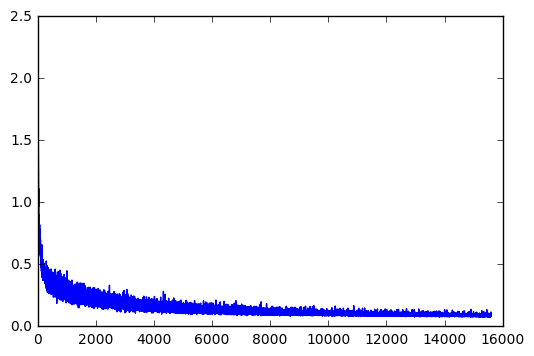

In [8]:
plt.plot(results_my['loss'])
plt.show()

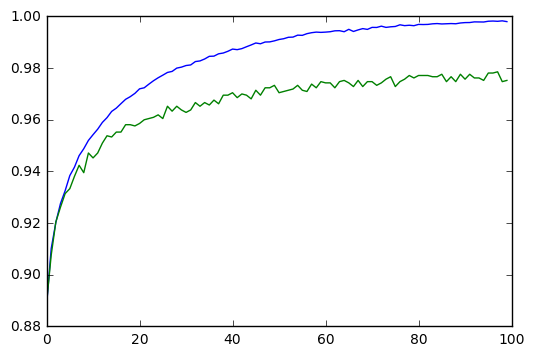

In [9]:
plt.plot(results_my['eval0'])
plt.plot(results_my['eval1'])
plt.show()

3.4727090510081964

In [11]:
for i in range(10):
    print(np.power(10, -(1+2*np.random.rand())))

0.00658256473649
0.00452425573209
0.0160634840096
0.00134465278379
0.00623265488058
0.0501864397719
0.0994895885759
0.00166304369779
0.0100795968368
0.00724565893193
